# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.314016,True,4.800033
1,-1.617921,False,-1.464545
2,-1.078612,False,-0.344630
3,-1.051626,False,-1.376793
4,-0.390615,True,5.651246
...,...,...,...
995,0.911334,True,5.669229
996,-1.218388,False,-0.797572
997,-1.438858,False,-0.345815
998,-0.410798,False,-0.024703


<AxesSubplot: xlabel='v0'>

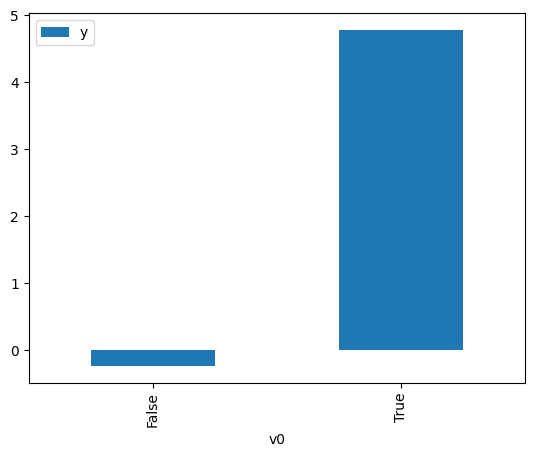

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

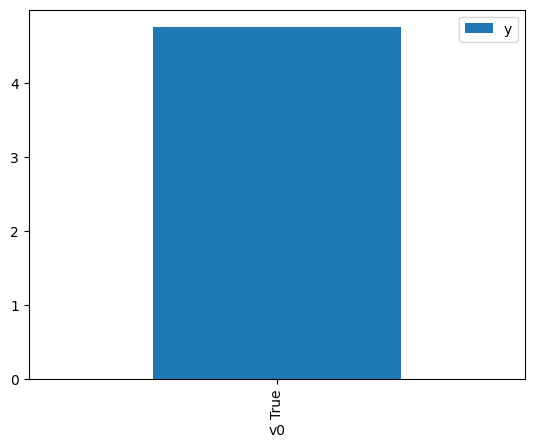

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.141956,False,-0.043405,0.915787,1.091957
1,0.110302,False,-0.572741,0.403207,2.480116
2,-0.137281,False,-1.117691,0.539226,1.854511
3,-0.946060,False,-0.203631,0.875640,1.142022
4,-3.157793,False,-0.562545,0.998951,1.001050
...,...,...,...,...,...
995,-1.105901,False,-1.081447,0.909409,1.099616
996,-0.776677,False,-0.959597,0.828629,1.206813
997,-0.800303,False,-0.787030,0.835945,1.196250
998,-1.180896,False,-1.136279,0.922216,1.084345


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,2.020721,True,6.789743,0.990349,1.009745
1,-1.178618,True,4.260586,0.078148,12.796267
2,-1.161765,True,6.130940,0.080885,12.363283
3,1.262388,True,4.500869,0.950188,1.052423
4,-0.314016,True,4.800033,0.366010,2.732166
...,...,...,...,...,...
995,1.123509,True,5.988665,0.933408,1.071343
996,-1.078173,True,4.152465,0.095789,10.439589
997,-1.688111,True,4.315355,0.026642,37.534751
998,-1.171202,True,4.683549,0.079342,12.603734


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.906
Model:                            OLS   Adj. R-squared (uncentered):              0.906
Method:                 Least Squares   F-statistic:                              4795.
Date:                Thu, 16 Mar 2023   Prob (F-statistic):                        0.00
Time:                        13:42:49   Log-Likelihood:                         -1415.0
No. Observations:                1000   AIC:                                      2834.
Df Residuals:                     998   BIC:                                      2844.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4102      0.028     14.456      0.000       0.355       0.466
x2             4.9261      0.053     92.227      0.000       4.821       5.031
==============================================================================
Omnibus:                        0.559   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.756   Jarque-Bera (JB):                0.640
Skew:                           0.045   Prob(JB):                        0.726
Kurtosis:                       2.915   Cond. No.                         1.95
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""